In [98]:
from MLimports2 import *
exec(MLimports())

In [99]:
# 1. Find the best model (hyper-parameters) for classification
# 2. Find the best models (hyper-parameters) for regression of short term incidents and long-term incidents
# 3. Find the best All-to-All regression model

# 10-fold cross-validation
#     1. Train on train-set and perform classification (divide incidents into two groups)
#     2. Use best model hyper-parameters to train regression model A-A, use samples based on the predicted duration
#     3. Use best model hyper-parameters to train regression model B-B, use samples based on the predicted duration
#     4. Collect predictions and estimate metrics

In [100]:
def mse(yt,yp):
    return mean_squared_error(yt,yp)

def rmse(yt,yp):
    return np.sqrt(mean_squared_error(yt,yp))


METRIC = {'name':'RMSE','instance':rmse}

In [155]:
#Table 5. Data set SF. All-to-All, A-to-A, B-to-B regression.
# best All-to-All model for the data set SF

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV as RCV

OPT={'name':'LGBM','instance':lgb.LGBMRegressor,'param':{
            'feature_fraction':np.linspace(0.5,1,100),'bagging_fraction':np.linspace(0.5,1,100),
            'learning_rate' : np.linspace(0.00001,1,10000), 'lambda_l1':np.linspace(0,5,1000),'lambda_l2':np.linspace(0,5,1000),
            'max_depth' : np.arange(2,15), 'metric':['MAE','RMSE'],'objective':['huber', 'gamma', 'fair', 'tweedie'],
        }}

X,Y = getBFS(part=[0,-1],dataset='sf')

reg = RCV(OPT['instance'](),OPT['param'],cv=10,n_jobs=20,random_state=1000,n_iter=250)
reg.fit(X,np.log1p(Y))
bestfullreg = OPT['instance'](**reg.best_params_)

[LightGBM] [Warning] lambda_l1 is set=0.10010010010010009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10010010010010009
[LightGBM] [Warning] bagging_fraction is set=0.8888888888888888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8888888888888888
[LightGBM] [Warning] feature_fraction is set=0.7929292929292929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7929292929292929
[LightGBM] [Warning] lambda_l2 is set=0.2802802802802803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2802802802802803


In [156]:
# best regression model for A part
X,Y = getBFS(part=[0,45],dataset='sf')

reg = RCV(OPT['instance'](),OPT['param'],cv=10,n_jobs=20,random_state=1000,n_iter=250)
reg.fit(X,Y)
bestAreg = OPT['instance'](**reg.best_params_)

In [157]:
# best regression model for B part
X,Y = getBFS(part=[45,-1],dataset='sf')

reg = RCV(OPT['instance'](),OPT['param'],cv=10,n_jobs=20,random_state=1000,n_iter=250)
reg.fit(X,Y)
bestBreg = OPT['instance'](**reg.best_params_)

In [158]:
bestBreg

LGBMRegressor(bagging_fraction=0.8888888888888888,
              feature_fraction=0.7929292929292929,
              lambda_l1=0.10010010010010009, lambda_l2=0.2802802802802803,
              learning_rate=0.07351661566156616, max_depth=8, metric='MAE',
              objective='fair')

In [160]:
#best classifier
OPT = {'name':'RF','instance': RandomForestClassifier, 'param':{
    'n_estimators' : np.arange(20,200,1),
    'max_depth':np.arange(2,15,1),
}}

from sklearn.preprocessing import binarize
X,Y = getBFS(part=[0,-1],dataset='sf')
X = X.values
Ybin = binarize(Y.reshape(-1,1),threshold=45).ravel()


cla = RCV(OPT['instance'](),OPT['param'],cv=10,n_jobs=20,random_state=1000,n_iter=250)
cla.fit(X,Ybin)

bestfullcla = OPT['instance'](**cla.best_params_)

In [164]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV    
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.preprocessing import binarize

X,Y = getBFS(part=[0,-1],dataset='sf')
X = X.values

# def quantilefold(X,Y):
#     zipped = list(zip(X,Y))
#     X = [A for A,B in sorted(zipped, key = lambda x: x[1])]
#     Y = [B for A,B in sorted(zipped, key = lambda x: x[1])]
#     X = np.array(X)
#     Y = np.array(Y)
#     return X,Y

# X,Y = quantilefold(X,Y)


Ybin = binarize(Y.reshape(-1,1),threshold=45).ravel()
Yfull = np.concatenate([Y.reshape(-1,1),Ybin.reshape(-1,1)],axis=1)

kf = KFold(n_splits=10,shuffle=True)
kf.get_n_splits(X,Yfull)

RES=[]

for train_index, test_index in kf.split(X,Yfull):
    
    Xtr, Xte = X[train_index], X[test_index]
    Ytr, Yte = Yfull[train_index], Yfull[test_index]
    
    # one regression model predictions
    reg = bestfullreg
    reg.fit(Xtr,np.log1p(Ytr[:,0]))
    Rpreds = np.expm1(reg.predict(Xte))
    RTrpreds = np.expm1(reg.predict(Xtr))
    
    # classification model predictions
    cla = bestfullcla
    cla.fit(Xtr,Ytr[:,1])
    Cpreds = cla.predict(Xte)
    CTrpreds = cla.predict(Xtr)
    
    # A- and B- models try to predict
    regA = bestAreg
    regB = bestBreg
    
    As = Ytr[:,1]==0
    Bs = Ytr[:,1]==1
    regA.fit(Xtr[As],np.log1p(Ytr[As,0]))
    regB.fit(Xtr[Bs],np.log1p(Ytr[Bs,0]))
    
    Apreds = np.expm1(regA.predict(Xte))
    Bpreds = np.expm1(regB.predict(Xte))
    
    ATrpreds = np.expm1(regA.predict(Xtr))
    BTrpreds = np.expm1(regB.predict(Xtr))
    # accumulating predictions
    
    
    # performing training on predictions on the training part
#     R3tr = np.concatenate([reg.predict(Xtr).reshape(-1,1), regA.predict(Xtr).reshape(-1,1), regB.predict(Xtr).reshape(-1,1), cla.predict(Xtr).reshape(-1,1)],axis=1)
#     R3te = np.concatenate([reg.predict(Xte).reshape(-1,1), regA.predict(Xte).reshape(-1,1), regB.predict(Xte).reshape(-1,1), cla.predict(Xte).reshape(-1,1)],axis=1)

    
    
#     full.fit(R3tr,np.log1p(Ytr[:,0]))
    
    # after training the fusion model - making predictions
#     PREDS = np.expm1(full.predict(R3te))
    
#     TRPREDS = []
    
#     for i in range(len(Xtr)):
        
#         if CTrpreds[i]==0:
#             TRPREDS.append(ATrpreds[i])
            
#         if CTrpreds[i]==1:
#             TRPREDS.append(BTrpreds[i])
            
    TEPREDS = []
    
    for i in range(len(Xte)):
        
        if Cpreds[i]==0:
            TEPREDS.append(Apreds[i])
            
        if Cpreds[i]==1:
            TEPREDS.append(Bpreds[i])  
    
    #pipeline predictions
#     TRPREDS = np.array(TRPREDS).reshape(-1,1)  
    TEPREDS = np.array(TEPREDS).reshape(-1,1)
    
    fusion = XGBRegressor()
    fusion.fit(np.concatenate([RTrpreds.reshape(-1,1),CTrpreds.reshape(-1,1),ATrpreds.reshape(-1,1),BTrpreds.reshape(-1,1)],axis=1), np.log1p(Ytr[:,0]))
    PREDS = fusion.predict(np.concatenate([Rpreds.reshape(-1,1),Cpreds.reshape(-1,1),Apreds.reshape(-1,1),Bpreds.reshape(-1,1)],axis=1))
    PREDS = np.expm1(PREDS)
#     PREDS=PREDS
    
    rA, rB = np.sqrt(mse(Yte[:,0],np.array(PREDS))), np.sqrt(mse(Yte[:,0],np.array(Rpreds)))
    
    rP = np.sqrt(mse(Yte[:,0],np.array(TEPREDS).ravel()))

    rA = np.round(rA)
    rB = np.round(rB)
    rP = np.round(rP)

    print("{},{},{}".format(rA, rB, rP))
    RES.append("{},{},{}".format(rA, rB, rP))

print("RMSEfusion,RMSEreg,RMSEpipe")
print("\n".join(RES))

[LightGBM] [Warning] lambda_l1 is set=0.10010010010010009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10010010010010009
[LightGBM] [Warning] bagging_fraction is set=0.8888888888888888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8888888888888888
[LightGBM] [Warning] feature_fraction is set=0.7929292929292929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7929292929292929
[LightGBM] [Warning] lambda_l2 is set=0.2802802802802803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2802802802802803
[LightGBM] [Warning] lambda_l1 is set=0.8308308308308309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8308308308308309
[LightGBM] [Warning] bagging_fraction is set=0.7626262626262627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7626262626262627
[LightGBM] [Warning] feature_fraction is set=0.7878787878787878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7878787878787

[LightGBM] [Warning] lambda_l1 is set=0.8308308308308309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8308308308308309
[LightGBM] [Warning] bagging_fraction is set=0.7626262626262627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7626262626262627
[LightGBM] [Warning] feature_fraction is set=0.7878787878787878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7878787878787878
[LightGBM] [Warning] lambda_l2 is set=2.7777777777777777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7777777777777777
47.0,50.0,53.0
[LightGBM] [Warning] lambda_l1 is set=0.10010010010010009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10010010010010009
[LightGBM] [Warning] bagging_fraction is set=0.8888888888888888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8888888888888888
[LightGBM] [Warning] feature_fraction is set=0.7929292929292929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

In [165]:
out = open('SF_fusion2.csv','w')
out.write("RMSEfusion,RMSEreg,RMSEpipe\n")
out.write("\n".join(RES))
out.close()

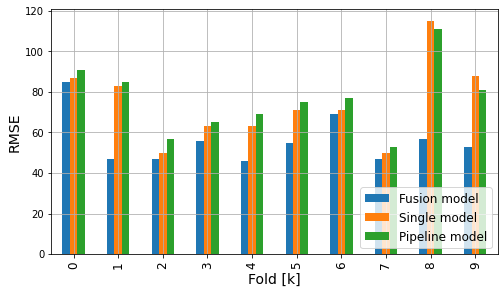

In [167]:
dt = pd.read_csv('SF_fusion2.csv')
dt = dt.rename({'RMSEfusion':'Fusion model','RMSEreg':'Single model','RMSEpipe':'Pipeline model'},axis=1)

# plt.figure()
dt.plot.bar(figsize=(8,4.5))
plt.ylabel('RMSE',fontsize=14)
plt.xlabel('Fold [k]',fontsize=14)
plt.legend(fontsize=12,loc='lower right')
plt.grid()
plt.xticks(np.arange(10),np.arange(10),fontsize=12)

print()

In [4]:
X,Y = getBFS(part=[0,-1],dataset='sf')
X = X.values

tpot = TPOTRegressor(generations=5, cv=10,template='Regressor',population_size=50, verbosity=2, n_jobs=30,random_state=42, scoring='neg_mean_squared_error',config_dict=tpotreg_config)
tpot.fit(X,np.log1p(Y))
# print(tpot.score(X,Y))
bestfullreg = tpot.fitted_pipeline_[0]

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.28362255070780235

Generation 2 - Current best internal CV score: -0.28362255070780235

Generation 3 - Current best internal CV score: -0.28362255070780235

Generation 4 - Current best internal CV score: -0.28362255070780235

Generation 5 - Current best internal CV score: -0.28362255070780235

Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.99, learning_rate=0.1, loss=lad, max_depth=9, max_features=0.6000000000000001, min_samples_leaf=12, min_samples_split=17, n_estimators=100, subsample=0.6000000000000001)


In [6]:
X,Y = getBFS(part=[0,40],dataset='sf')
X = X.values

tpot = TPOTRegressor(generations=5, cv=10, template='Regressor',population_size=50, verbosity=2, n_jobs=30,random_state=42, scoring='neg_mean_squared_error',config_dict=tpotreg_config)
tpot.fit(X,np.log1p(Y))
# print(tpot.score(X,Y))
bestAreg = tpot.fitted_pipeline_[0]

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.015318264676631676

Generation 2 - Current best internal CV score: -0.014913248709005792

Generation 3 - Current best internal CV score: -0.014629825111804806

Generation 4 - Current best internal CV score: -0.014629825111804806

Generation 5 - Current best internal CV score: -0.014629825111804806

Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.99, learning_rate=0.1, loss=lad, max_depth=9, max_features=0.45, min_samples_leaf=12, min_samples_split=17, n_estimators=100, subsample=0.6000000000000001)


In [7]:
X,Y = getBFS(part=[40,-1],dataset='sf')
X = X.values

tpot = TPOTRegressor(generations=5, cv=10, template='Regressor',population_size=50, verbosity=2, n_jobs=30,random_state=42, scoring='neg_mean_squared_error',config_dict=tpotreg_config)
tpot.fit(X,np.log1p(Y))
# print(tpot.score(X,Y))
bestBreg = tpot.fitted_pipeline_[0]

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.2023757211233609

Generation 2 - Current best internal CV score: -0.2023757211233609

Generation 3 - Current best internal CV score: -0.20031564276479408

Generation 4 - Current best internal CV score: -0.19457925256068012

Generation 5 - Current best internal CV score: -0.1942929066981764

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=4, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.25, verbosity=0)


In [8]:
from sklearn.preprocessing import binarize
X,Y = getBFS(part=[0,-1],dataset='sf')
X = X.values
Ybin = binarize(Y.reshape(-1,1),threshold=40).ravel()

from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, cv=10, scoring='f1', template='Classifier',population_size=50, verbosity=2, n_jobs=30,random_state=42,config_dict=tpotcla_config)
tpot.fit(X,Ybin)
# print(tpot.score(X,Ybin))
bestfullcla = tpot.fitted_pipeline_[0]

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7203215476650155

Generation 2 - Current best internal CV score: 0.7203215476650155

Generation 3 - Current best internal CV score: 0.7203215476650155

Generation 4 - Current best internal CV score: 0.7203215476650155

Generation 5 - Current best internal CV score: 0.7203215476650155

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.001, max_depth=8, max_features=0.05, min_samples_leaf=12, min_samples_split=9, n_estimators=100, subsample=0.55)


In [11]:
from sklearn.model_selection import KFold

from sklearn.preprocessing import binarize
X,Y = getBFS(part=[0,-1],dataset='sf')
X = X.values

# def quantilefold(X,Y):
#     zipped = list(zip(X,Y))
#     X = [A for A,B in sorted(zipped, key = lambda x: x[1])]
#     Y = [B for A,B in sorted(zipped, key = lambda x: x[1])]
#     X = np.array(X)
#     Y = np.array(Y)
#     return X,Y

# X,Y = quantilefold(X,Y)


Ybin = binarize(Y.reshape(-1,1),threshold=40).ravel()
Yfull = np.concatenate([Y.reshape(-1,1),Ybin.reshape(-1,1)],axis=1)

kf = KFold(n_splits=10,shuffle=True)
kf.get_n_splits(X,Yfull)

print("RMSEfull,RMSEreg")

RES=[]

for train_index, test_index in kf.split(X,Yfull):
    
    # reset models (since some may use iterative training)
#     bestAreg.fit([[0],[0]],[0,0])
#     bestBreg.fit([[0],[0]],[0,0])
#     bestfullreg.fit([[0],[0]],[0,0])
#     bestfullcla.fit([[0],[0]],[0,1])
#     print()
    
    Xtr, Xte = X[train_index], X[test_index]
    Ytr, Yte = Yfull[train_index], Yfull[test_index]
    
    # one regression model predictions
    reg = bestfullreg
    reg.fit(Xtr,np.log1p(Ytr[:,0]))
    Rpreds = np.expm1(reg.predict(Xte))
    RTrpreds = np.expm1(reg.predict(Xtr))
    
    #one classification model predictions
    cla = bestfullcla
    cla.fit(Xtr,Ytr[:,1])
    Cpreds = cla.predict(Xte)
    CTrpreds = cla.predict(Xtr)
    
    
    # A- and B- models try to predict
    regA = bestAreg
    regB = bestBreg
    
    As = Ytr[:,1]==0
    Bs = Ytr[:,1]==1
    regA.fit(Xtr[As],np.log1p(Ytr[As,0]))
    regB.fit(Xtr[Bs],np.log1p(Ytr[Bs,0]))
    
    Apreds = np.expm1(regA.predict(Xte))
    Bpreds = np.expm1(regB.predict(Xte))
    
    ATrpreds = np.expm1(regA.predict(Xtr))
    BTrpreds = np.expm1(regB.predict(Xtr))
    #accumulating predictions
    
    R3tr = np.concatenate([reg.predict(Xtr).reshape(-1,1), regA.predict(Xtr).reshape(-1,1), regB.predict(Xtr).reshape(-1,1), cla.predict(Xtr).reshape(-1,1)],axis=1)
    R3te = np.concatenate([reg.predict(Xte).reshape(-1,1), regA.predict(Xte).reshape(-1,1), regB.predict(Xte).reshape(-1,1), cla.predict(Xte).reshape(-1,1)],axis=1)
#     print(R3tr.shape,Ytr[:,0].shape)

    from sklearn.linear_model import RidgeCV
    
    from sklearn.tree import DecisionTreeRegressor as DTR
    full = XGBRegressor()#DTR(max_depth=4)
#     full = TPOTRegressor(generations=5, template='Regressor',population_size=40, verbosity=2, n_jobs=20,random_state=42, scoring='neg_mean_squared_error',config_dict=tpotreg_config)
    full.fit(R3tr,np.log1p(Ytr[:,0]))
#     bestfullreg.fit([[0],[0]],[0,0])
#     finalreg = bestfullreg
#     finalreg.fit(R3tr,Ytr[:,0])
    
    
    PREDS = np.expm1(full.predict(R3te))
    
    
    
    TRPREDS = []
    
    for i in range(len(Xtr)):
        
        if CTrpreds[i]==0:
            TRPREDS.append(ATrpreds[i])
            
        if CTrpreds[i]==1:
            TRPREDS.append(BTrpreds[i])
            
    TEPREDS = []
    
    for i in range(len(Xte)):
        
        if Cpreds[i]==0:
            TEPREDS.append(Apreds[i])
            
        if Cpreds[i]==1:
            TEPREDS.append(Bpreds[i])  
    TRPREDS = np.array(TRPREDS).reshape(-1,1)  
    
#     print(TRPREDS.shape)
    TEPREDS = np.array(TEPREDS).reshape(-1,1)
#     print(TEPREDS.shape)
    
    full.fit(np.concatenate([RTrpreds.reshape(-1,1),CTrpreds.reshape(-1,1),ATrpreds.reshape(-1,1),BTrpreds.reshape(-1,1)],axis=1), np.log1p(Ytr[:,0]))
    PREDS = full.predict(np.concatenate([Rpreds.reshape(-1,1),Cpreds.reshape(-1,1),Apreds.reshape(-1,1),Bpreds.reshape(-1,1)],axis=1))
    PREDS = np.expm1(PREDS)
#     PREDS=PREDS
    
    rA, rB = np.sqrt(mse(Yte[:,0],np.array(PREDS))), np.sqrt(mse(Yte[:,0],np.array(Rpreds)))

    rA = np.round(rA)
    rB = np.round(rB)

    print("{},{}".format(rA, rB))
    RES.append("{},{}".format(rA, rB))
#     print(PREDS[0],Rpreds[0])


print("RMSEfull,RMSEreg")
print("\n".join(RES))

RMSEfull,RMSEreg
52.0,100.0
109.0,135.0
56.0,110.0
45.0,60.0
44.0,49.0
45.0,46.0
51.0,56.0
59.0,59.0
45.0,52.0
80.0,95.0
RMSEfull,RMSEreg
52.0,100.0
109.0,135.0
56.0,110.0
45.0,60.0
44.0,49.0
45.0,46.0
51.0,56.0
59.0,59.0
45.0,52.0
80.0,95.0
